In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from statsmodels.tsa.api import VAR, DynamicVAR, VARMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import Holt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pyramid.arima import auto_arima
import pytemperature
from itertools import product

In [2]:
nights = pd.read_csv('DS/nights_2010-2017.csv', index_col='date', parse_dates=['date'], 
                          usecols=[*range(1, 15)])
nights.index.freq = 'MS'
temp = pd.read_csv('DS/avgtemp_2010-2017.csv',parse_dates=['date'],index_col='date',usecols=[*range(1, 15)])
temp = pytemperature.c2k(temp)
daysoff = pd.read_csv('DS/daysoff_2010-2017.csv',parse_dates=['date'],index_col='date',usecols=['date','daysoff'])
gdp = pd.read_csv('DS/regionalGDP_2010-2015.csv',parse_dates=['date'],index_col='date',usecols=[*range(1, 15)])

In [3]:
def seasonal_MASE(last_season, this_season, forecast):
    '''
    Parameters
    ----------
    last_season: array containing data for last season (size S)
    
    current_truth: array containing data for current season (size S)
    
    forecast: array containing data predictiing current season (size S)
    '''
    forecast_errors = np.abs(this_season - forecast)
    #print(forecast_errors)
    mean_absolute_forecast_error = np.average(forecast_errors)
    #print('forecast MAE', mean_absolute_forecast_error)
    
    naive = last_season
    naive.index = this_season.index
    naive_errors = np.abs(this_season - naive)
    #print(naive_errors)
    mean_absolute_naive_error = np.average(naive_errors)
    #print('naive MAE', mean_absolute_naive_error)
    
    return mean_absolute_forecast_error / mean_absolute_naive_error

In [4]:
args = {
    'region': ['PDL', 'BRE', 'OCC', 'COR'],
    'with_gdp': [False, True],
    'trend_model': ['Holt', 'ARIMA'],
    'lag': range(5,16),
    # periods is a tuple of (training start year, training end year, test year)
    'periods': [('2010-01-01', f'{end_year}-01-01', f'{end_year + 1}-01-01')
                 for end_year in range(2012, 2017)]
}

error_df = pd.DataFrame(columns=list(args.keys()) + ['MAE', 'RMSE', 'Max_error', 'MASE'])

for region, with_gdp, trend_model, lag, periods in product(*args.values()):
    start_year, end_year, predict_year = periods
    input_data = pd.concat([nights, temp, daysoff, gdp], axis=1).dropna()
    input_data = input_data[[f'nights_{region}',
                             f'avgtemp_{region}',
                             f'gdp_{region}',
                             'daysoff']]
    target = nights[[f'nights_{region}']]

    training_period = (input_data.index>=start_year)&(input_data.index<end_year) 
    testing_period = (target.index>=end_year)&(target.index<predict_year)

    train_data = input_data[training_period]
    test_data = np.array(target[testing_period])

    if not with_gdp:
        train_data.drop(f'gdp_{region}', axis=1)

    # --------Seasonal decompose----------
    decomposed_data = seasonal_decompose(
        train_data, model='multiplicative', extrapolate_trend='freq')  
    seasonal_data, trend_data, residual_data = (decomposed_data.seasonal,
                                                decomposed_data.trend, decomposed_data.resid)

    # ---------Seasonal prediction (Same as last year of training data)---------
    seasonal_train = seasonal_data[
        (seasonal_data.index>=start_year)&(seasonal_data.index<end_year)]
    seasonal_forecast = pd.DataFrame(seasonal_train[f'nights_{region}'].values[-12:])

    # --------Trend prediction (Linear Holt)----------
    if trend_model == 'Holt':
        trend = Holt(trend_data[f'nights_{region}']).fit(optimized=True)
        trend_forecast = pd.DataFrame(trend.predict(start=0, end=11).values)

    elif trend_model == 'ARIMA':
        trend = auto_arima(trend_data[f'nights_{region}'], 
                     start_p=0, start_q=0, max_p=20, max_q=20, m=12, 
                     start_P=0, max_P=20, seasonal=True, max_d=2, max_D=2, 
                     trace=False, error_action='ignore', suppress_warnings=True, 
                     stepwise=True, random=True, random_state=42) 
        trend_forecast = pd.DataFrame(trend.predict(n_periods=12))

    # --------Residual prediction (VAR)----------
    resid_model = VAR(residual_data, dates=residual_data.index)    
    resid_results = resid_model.fit(lag)
    lag_order = resid_results.k_ar
    resid_forecast = pd.DataFrame(
        resid_results.forecast(residual_data.values[-lag_order:], 12))

    # --------Recomposing results----------
    forecast = seasonal_forecast[0] * trend_forecast[0] * resid_forecast[0]

    # --------Calculated error measures for each CV step----------
    rmse_test = np.sqrt(mean_squared_error(test_data, forecast))
    mae_test = mean_absolute_error(test_data, forecast)
    years_train_data = len(train_data.index.strftime('%Y').unique().tolist())

    test = pd.Series(test_data[:,0],
                     index=target[f'nights_{region}'][testing_period].index)
    forecast.index = target[f'nights_{region}'][testing_period].index
    
    mase = seasonal_MASE(target[str(int(end_year[:4]) - 1)], target[end_year[:4]], forecast[0])
    max_error = np.max(np.abs(forecast - test)) / test[forecast.idxmax(
        np.abs(forecast - test))]
    new_row = {
        'region': region,
        'lag': lag,
        'periods': years_train_data,
        'trend_model': trend_model, 
        'with_gdp': with_gdp,
        'MAE': mae_test,
        'RMSE': rmse_test,
        'Max_error': max_error,
        'MASE': mase,
    }
    error_df = error_df.append(new_row, ignore_index=True)

C:\Users\franc\Anaconda3\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:707: RuntimeWarning: divide by zero encountered in true_divide
  omega = sse / df_resid
C:\Users\franc\Anaconda3\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:707: RuntimeWarning: divide by zero encountered in true_divide
  omega = sse / df_resid
C:\Users\franc\Anaconda3\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:707: RuntimeWarning: divide by zero encountered in true_divide
  omega = sse / df_resid
C:\Users\franc\Anaconda3\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:707: RuntimeWarning: divide by zero encountered in true_divide
  omega = sse / df_resid
C:\Users\franc\Anaconda3\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:707: RuntimeWarning: divide by zero encountered in true_divide
  omega = sse / df_resid
C:\Users\franc\Anaconda3\lib\site-packages\statsmodels\tsa\vector_ar\var_model.py:707: RuntimeWarning: divide by zero encountered in true_divide
  ome

In [5]:
#Generated dataframe with error measures for each parameter/region
error_df.tail(5)

,region,with_gdp,trend_model,lag,periods,MAE,RMSE,Max_error,MASE
875,COR,True,ARIMA,15,2,17.048687,27.151763,0.105987,20.942344
876,COR,True,ARIMA,15,3,14.597532,22.420321,0.101122,25.624346
877,COR,True,ARIMA,15,4,34.570042,55.234271,0.280196,14.922260
878,COR,True,ARIMA,15,5,44.353080,70.385569,0.371041,13.727596
879,COR,True,ARIMA,15,6,57.379556,92.670745,0.386124,20.030721


In [6]:
#Lowest MASE by region and their respective settings
for reg, group in error_df.groupby('region'):
    print(group.loc[group.MASE.idxmin()])

region              BRE
with_gdp          False
trend_model       ARIMA
lag                  12
periods               2
MAE             40.4808
RMSE            54.2625
Max_error      0.144958
MASE            8.39254
Name: 310, dtype: object
region               COR
with_gdp           False
trend_model         Holt
lag                    7
periods                5
MAE              15.0259
RMSE             18.5912
Max_error      0.0583284
MASE             13.3005
Name: 673, dtype: object
region             OCC
with_gdp         False
trend_model       Holt
lag                 15
periods              6
MAE            87396.7
RMSE            148756
Max_error      530.273
MASE           11.4498
Name: 494, dtype: object
region               PDL
with_gdp           False
trend_model        ARIMA
lag                   13
periods                6
MAE              20.1558
RMSE             28.9793
Max_error      0.0845476
MASE             5.33672
Name: 99, dtype: object


In [7]:
#Lowest MASE out of all regions
error_df.loc[error_df.MASE.idxmin()]

region               PDL
with_gdp           False
trend_model        ARIMA
lag                   13
periods                6
MAE              20.1558
RMSE             28.9793
Max_error      0.0845476
MASE             5.33672
Name: 99, dtype: object

In [11]:
#Highest MASE out of all regions
error_df.loc[error_df.MASE.idxmax()]

region              COR
with_gdp          False
trend_model       ARIMA
lag                  14
periods               3
MAE             13.3899
RMSE            23.4719
Max_error      0.112161
MASE            25.6452
Name: 761, dtype: object

In [14]:
len(error_df.query("with_gdp == False and lag < 14"))

360

In [16]:
len(error_df.query("with_gdp == False"))

440

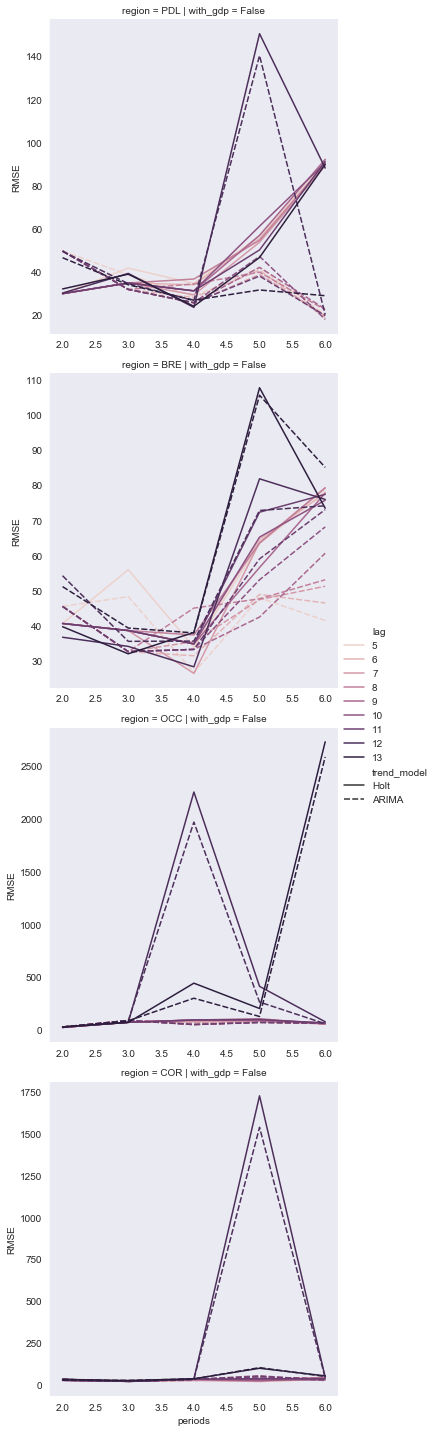

In [9]:
#With or without GDP for each region
sns.set_style("dark")
error_df.lag = error_df.lag.astype('int')

gdp_plots = sns.relplot(x='periods', y='RMSE',
            hue='lag', style='trend_model',
            row='region',
            col='with_gdp',
            kind='line', legend='full',
            data=error_df.query("with_gdp == False and lag < 14"),
            facet_kws={'sharex': False, 'sharey': False})

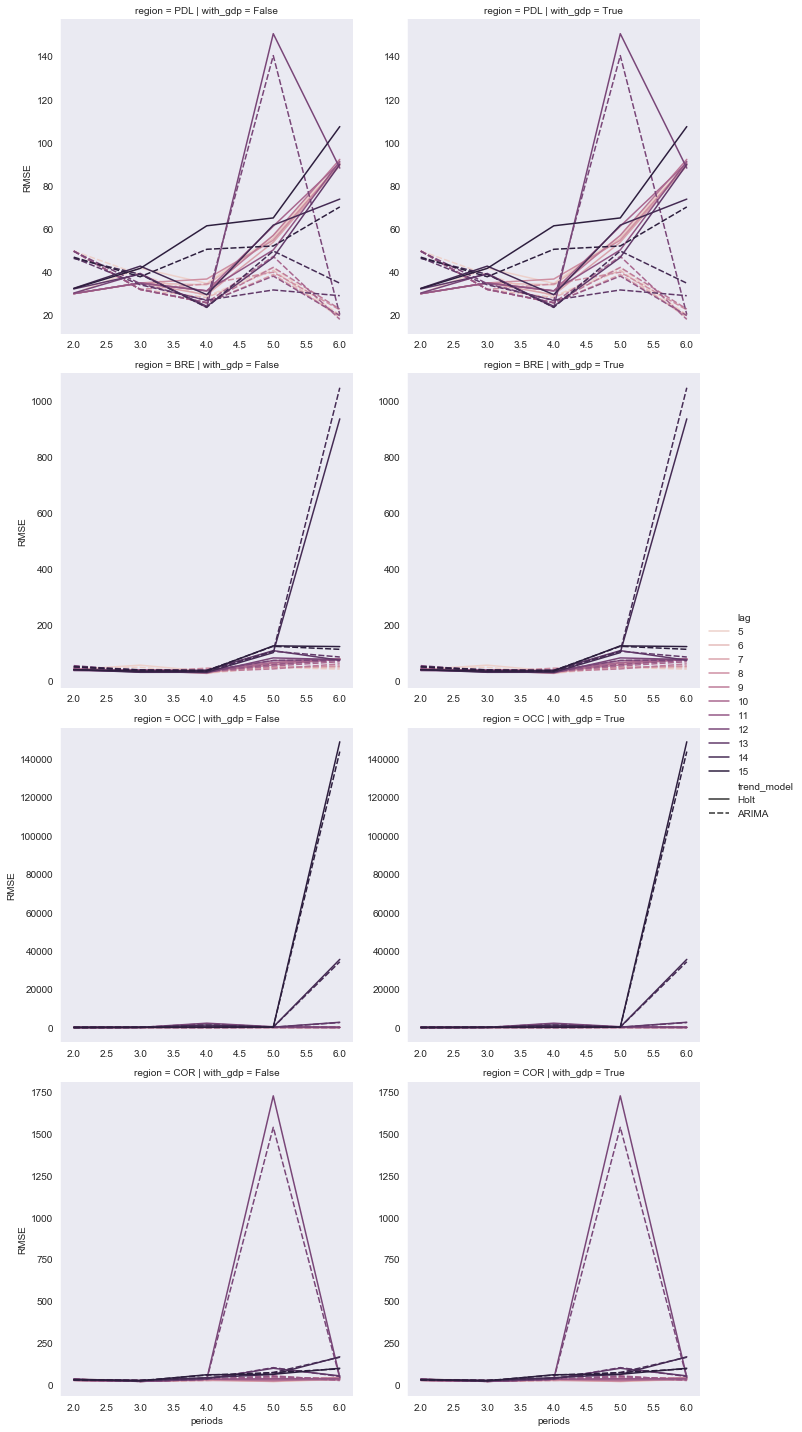

In [10]:
#With or without GDP for each region
sns.set_style("dark")
error_df.lag = error_df.lag.astype('int')

gdp_plots = sns.relplot(x='periods', y='RMSE',
            hue='lag', style='trend_model',
            row='region',
            col='with_gdp',
            kind='line', legend='full',
            data=error_df,
            facet_kws={'sharex': False, 'sharey': False})

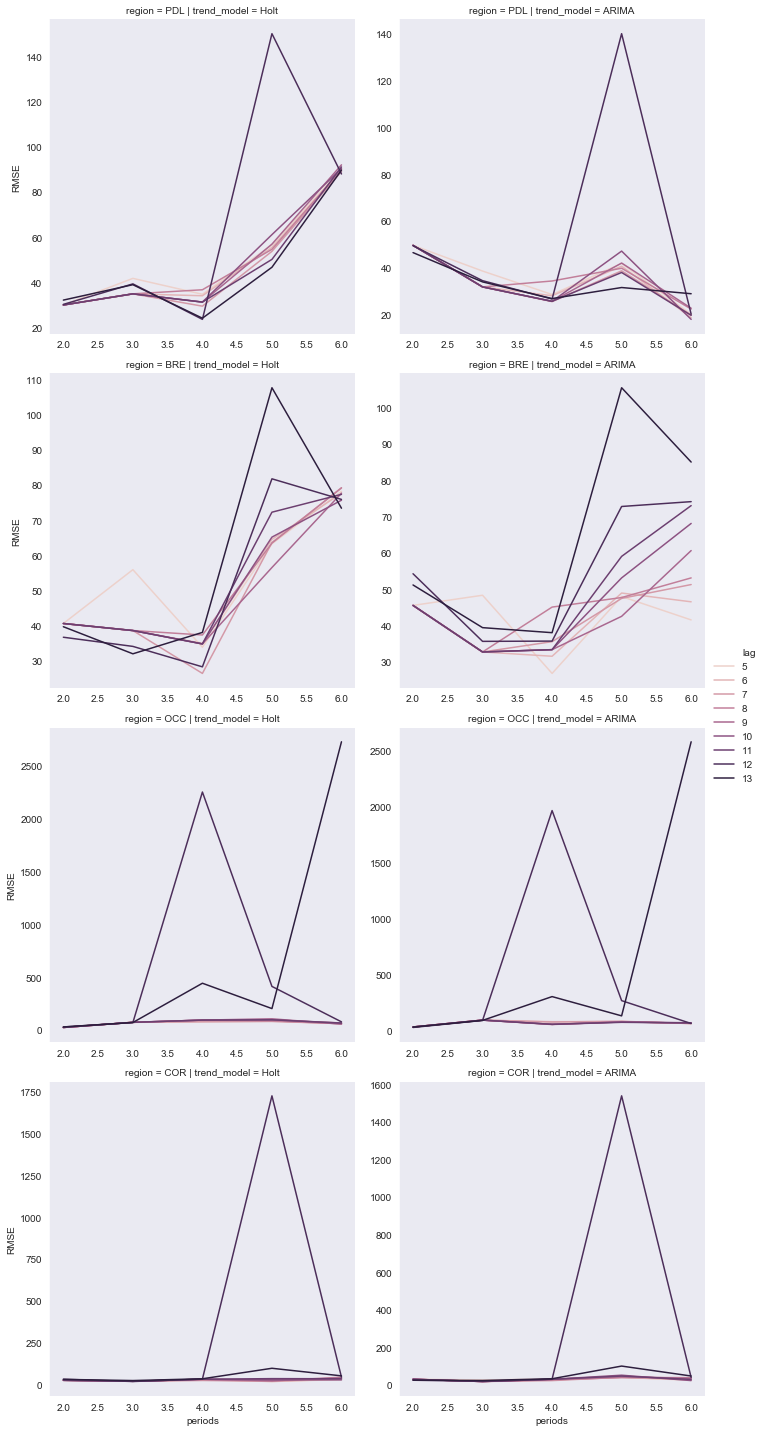

In [17]:
#Holt vs. Seasonal ARIMA for Trend
g = sns.relplot(x='periods', y='RMSE',
            hue='lag', 
            row='region', col='trend_model',
            kind='line', legend='full',
            data=error_df.query("with_gdp == False and lag < 14"),
            facet_kws={'sharex': False, 'sharey': False})

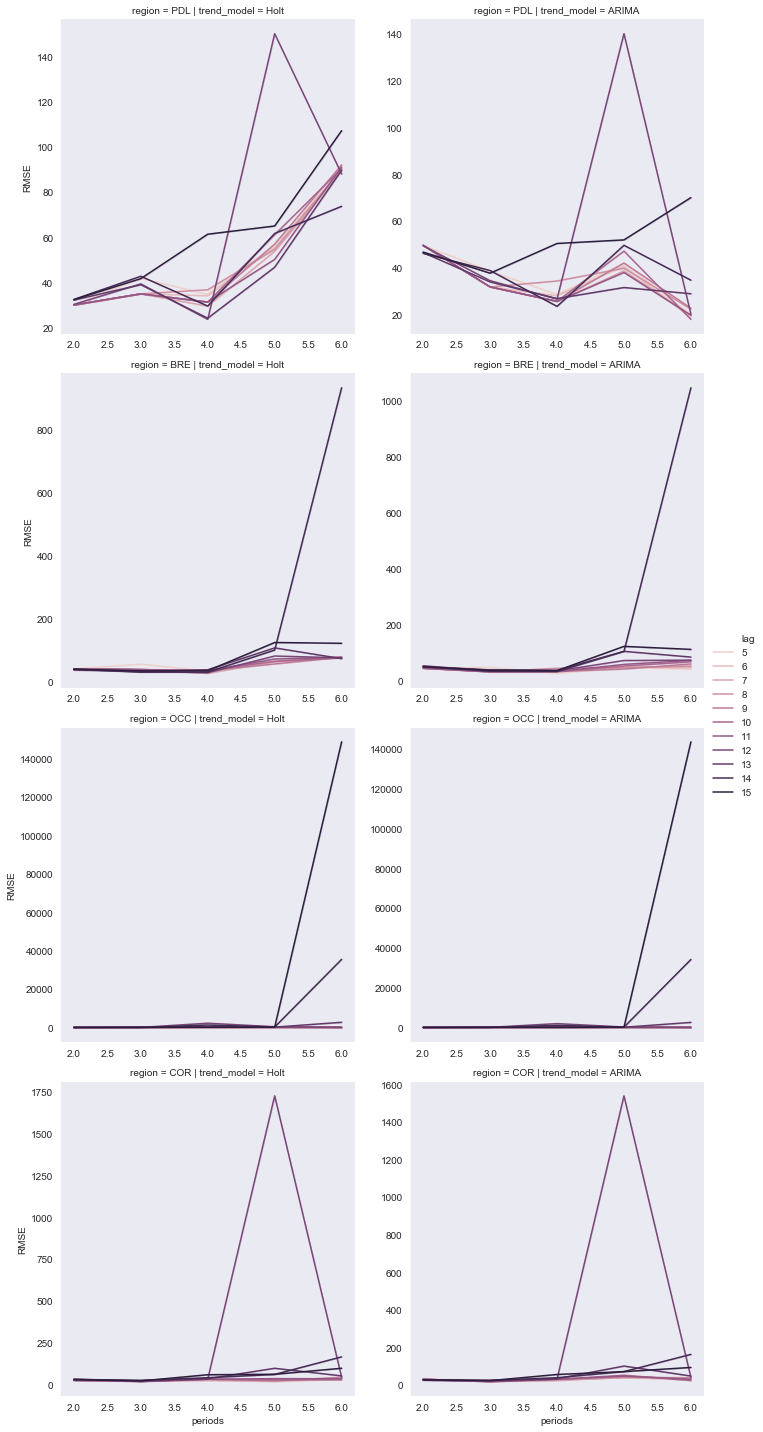

In [18]:
#Holt vs. Seasonal ARIMA for Trend
g = sns.relplot(x='periods', y='RMSE',
            hue='lag', 
            row='region', col='trend_model',
            kind='line', legend='full',
            data=error_df,
            facet_kws={'sharex': False, 'sharey': False})

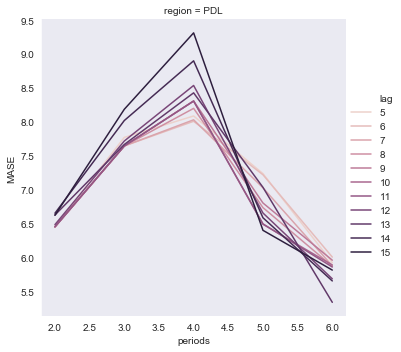

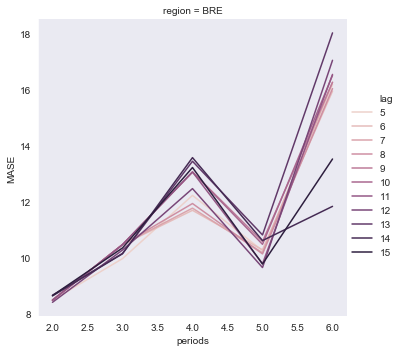

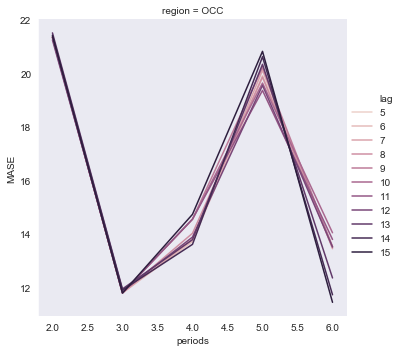

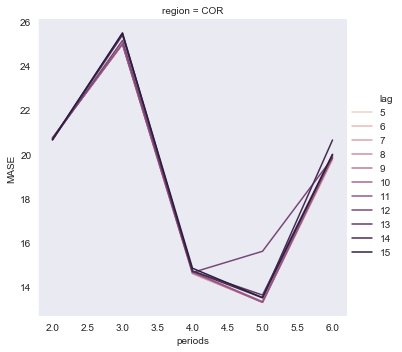

In [13]:
#MASE for each region
sns.relplot(x='periods', y='MASE',
            hue='lag', 
            row='region',
            kind='line', legend='full',
            data=error_df.query("region == 'PDL' and with_gdp == False and trend_model == 'ARIMA'"))

sns.relplot(x='periods', y='MASE',
            hue='lag', 
            row='region',
            kind='line', legend='full',
            data=error_df.query("region == 'BRE' and with_gdp == False and trend_model == 'ARIMA'"))

sns.relplot(x='periods', y='MASE',
            hue='lag', 
            row='region',
            kind='line', legend='full',
            data=error_df.query("region == 'OCC' and with_gdp == False and trend_model == 'Holt'"))

sns.relplot(x='periods', y='MASE',
            hue='lag', 
            row='region',
            kind='line', legend='full',
            data=error_df.query("region == 'COR' and with_gdp == False and trend_model == 'Holt'"))

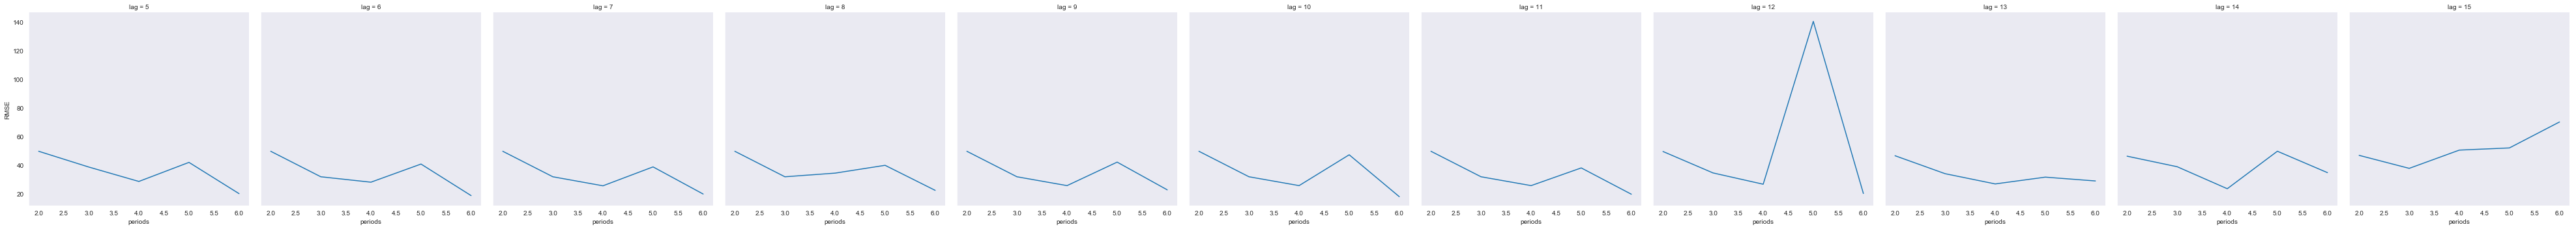

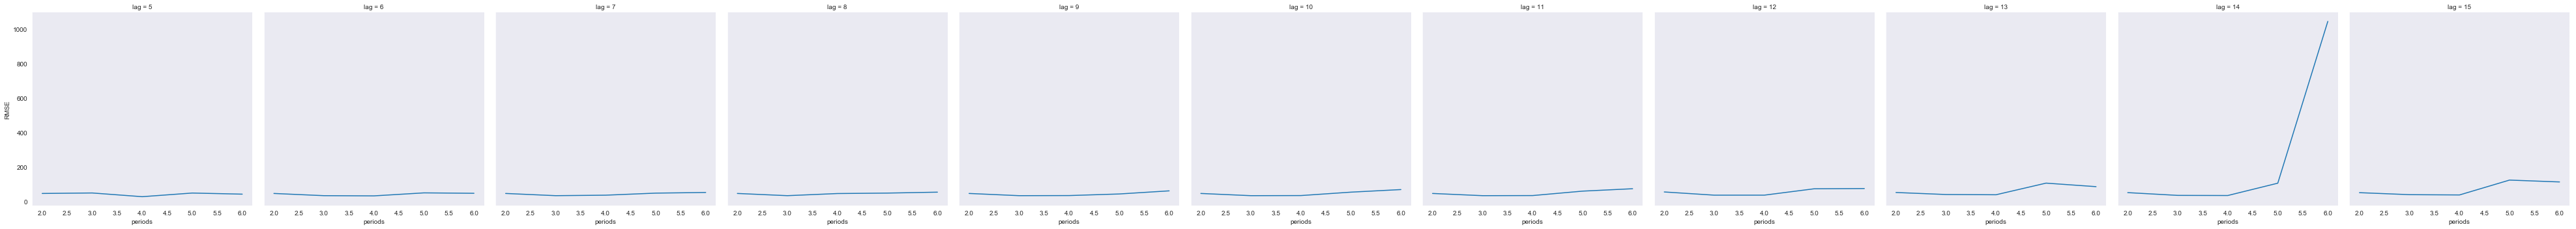

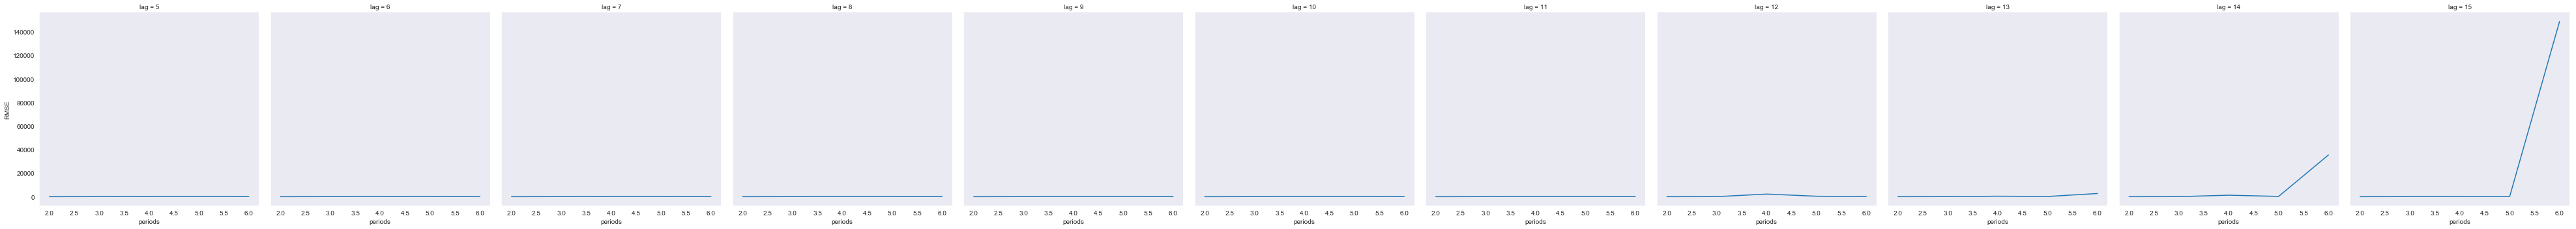

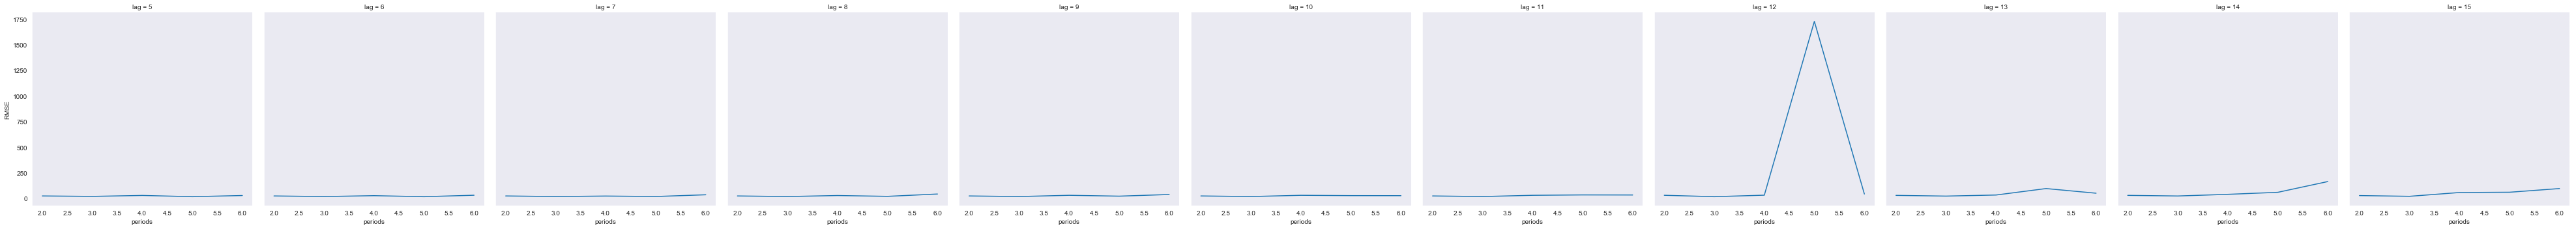

In [19]:
#RMSE for each lag for each region
sns.relplot(x='periods', y='RMSE',
            col='lag', 
            kind='line', legend='full',
            data=error_df.query("region == 'PDL' and with_gdp == False and trend_model == 'ARIMA'"))

sns.relplot(x='periods', y='RMSE',
            col='lag',
            kind='line', legend='full',
            data=error_df.query("region == 'BRE' and with_gdp == False and trend_model == 'ARIMA'"))

sns.relplot(x='periods', y='RMSE',
            col='lag',
            kind='line', legend='full',
            data=error_df.query("region == 'OCC' and with_gdp == False and trend_model == 'Holt'"))

sns.relplot(x='periods', y='RMSE',
            col='lag',
            kind='line', legend='full',
            data=error_df.query("region == 'COR' and with_gdp == False and trend_model == 'Holt'"))

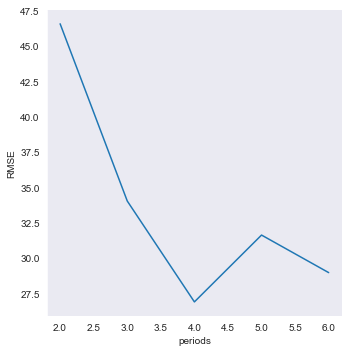

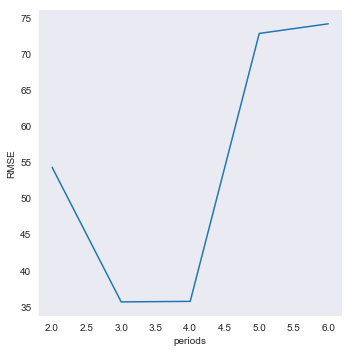

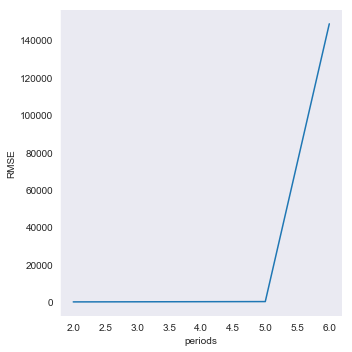

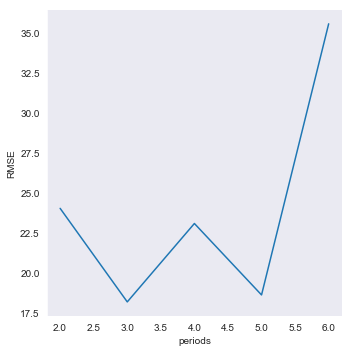

In [20]:
#RMSE for region with chosen lags
sns.relplot(x='periods', y='RMSE',
            kind='line', legend='full',
            data=error_df.query("region == 'PDL' and with_gdp == False and trend_model == 'ARIMA' and lag == 13"))

sns.relplot(x='periods', y='RMSE',
            kind='line', legend='full',
            data=error_df.query("region == 'BRE' and with_gdp == False and trend_model == 'ARIMA' and lag == 12"))

sns.relplot(x='periods', y='RMSE',
            kind='line', legend='full',
            data=error_df.query("region == 'OCC' and with_gdp == False and trend_model == 'Holt' and lag == 15"))

sns.relplot(x='periods', y='RMSE',
            kind='line', legend='full',
            data=error_df.query("region == 'COR' and with_gdp == False and trend_model == 'Holt' and lag == 7"))

In [21]:
#Average error measures for the chosen model

print('Average error and MASE for PDL, no GDP, ARIMA, lag=13')
print(error_df[(error_df.region=='PDL')&(error_df.with_gdp==False)&(error_df.trend_model=='ARIMA')&(error_df.lag==13)].mean())
print('----')

print('Average error and MASE for BRE, no GDP, ARIMA, lag=12')
print(error_df[(error_df.region=='BRE')&(error_df.with_gdp==False)&(error_df.trend_model=='ARIMA')&(error_df.lag==12)].mean())
print('----')

print('Average error and MASE for OCC, no GDP, Holt, lag=15')
print(error_df[(error_df.region=='OCC')&(error_df.with_gdp==False)&(error_df.trend_model=='Holt')&(error_df.lag==15)].mean())
print('----')

print('Average error and MASE for COR, no GDP, Holt, lag=7')
print(error_df[(error_df.region=='COR')&(error_df.with_gdp==False)&(error_df.trend_model=='Holt')&(error_df.lag==7)].mean())
print('----')

Average error and MASE for PDL, no GDP, ARIMA, lag=13
lag          13.000000
MAE          26.941453
RMSE         33.626081
Max_error     0.083832
MASE          7.018528
dtype: float64
----
Average error and MASE for BRE, no GDP, ARIMA, lag=12
lag          12.000000
MAE          42.305510
RMSE         54.506764
Max_error     0.115025
MASE         11.562775
dtype: float64
----
Average error and MASE for OCC, no GDP, Holt, lag=15
lag             15.000000
MAE          17549.022922
RMSE         29842.015074
Max_error      106.142450
MASE            16.046056
dtype: float64
----
Average error and MASE for COR, no GDP, Holt, lag=7
lag           7.000000
MAE          16.775314
RMSE         23.869124
Max_error     0.083134
MASE         18.688425
dtype: float64
----
